## Reference
https://www.analyticsvidhya.com/blog/2021/08/sentiment-analysis-using-bidirectional-stacked-lstm/

In [29]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

# For preprocessing
import re 
import nltk
import string
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import SnowballStemmer
import pickle
from collections import Counter  #to count elements in list

# For Building the model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import ticker
%matplotlib inline
import seaborn as sns

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loding the data set

In [30]:
df = pd.read_csv('train_sentiment.csv')

## Preprocessing

In [34]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205075 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   category  205068 non-null  float64
 1   text      204971 non-null  object 
dtypes: float64(1), object(1)
memory usage: 4.7+ MB
None


<AxesSubplot:title={'center':'different catagories'}, ylabel='category'>

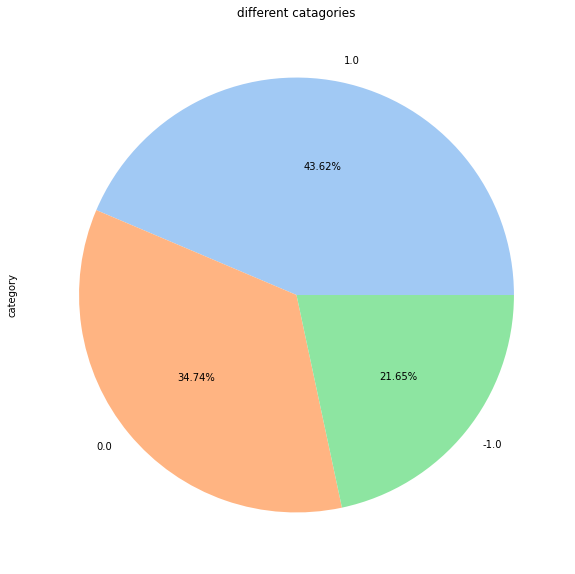

In [35]:
color = sns.color_palette('pastel')[0:df.category.nunique()]
df['category'].value_counts().plot.pie(figsize =(18,10) , 
                                           autopct='%.2f%%', 
                                           title = 'different catagories',
                                           colors =color )

In [36]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', str(string))


def Clean_text(text):
    text= re.sub('@[A-Za-z0-9]+','',text ) #removing mentions
    text = re.sub(r"[^a-zA-Z0-9]", " ", text) # Removing non letters
    text= re.sub("#",'',text) #removing #
    text= re.sub('RT[\s]+','',text) # removing Retexts
    text= re.sub('https?:\/\/\S+','',text) #removing links
    text= re.sub("[+%|):'@(€¥£—•;=*]"," ",text)
    text= re.sub(r'[^\x00-\x7F]+',' ', text)
    text= text.lower()
    return text

In [37]:
df['text'] = df["text"].apply(remove_emoji)
df['text'] = df["text"].apply(Clean_text)

In [38]:
df['text'] = df['text'].str.replace('\d+', '')
df["text"] = df["text"].str.replace("?"," ")
df["text"] = df["text"].str.replace("!"," ")
df["text"] = df["text"].str.replace("_"," ")
df["text"] = df["text"].str.replace(","," ")
df["text"] = df["text"].str.replace("&"," ")
df["text"] = df["text"].str.replace("\n"," ")
df["text"] = df["text"].str.replace("/"," ")
df["text"] = df["text"].str.replace("-"," ")
df["text"] = df["text"].str.replace("$"," ")
df["text"] = df["text"].str.replace("\r"," ")
df["text"] = df["text"].str.replace("."," ")
df["text"] = df["text"].str.replace("~"," ")
df["text"] = df["text"].str.replace("["," ")
df["text"] = df["text"].str.replace("]"," ")

In [39]:
stop_words = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [40]:
df

,category,text
0,0.0,according gran company plans move production r...
1,0.0,technopolis plans develop stages area less squ...
2,-1.0,international electronic industry company elco...
3,1.0,new production plant company would increase ca...
4,1.0,according company updated strategy years baswa...
...,...,...
162975,-1.0,crores paid neerav modi recovered congress lea...
162976,-1.0,dear rss terrorist payal gawar modi killing pl...
162977,0.0,cover interaction forum left
162978,0.0,big project came india modi dream project happ...


In [41]:
def text_to_words(text):
# tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

In [ ]:
X = list(map(text_to_words, df['text']))

In [ ]:
# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['category'])

In [ ]:
len(X)

In [ ]:
y = pd.get_dummies(df['category'])

In [ ]:
# Train and test split
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

## Bag of words (BOW) feature extraction

In [ ]:
vocabulary_size = len(X)

count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

In [ ]:
# Plot the BoW feature vector
plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

## Tokenizing & Padding

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=64

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

In [ ]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
## Traintest split

y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

In [ ]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Bidirectional LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 64
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

In [ ]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))

In [ ]:
# Save the model architecture & the weights
model.save('model.h5')
print('Model saved')

In [ ]:
from keras.models import load_model

# Load model
model = load_model('model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = [-1, 0, 1]
    max_len=64
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

## Lets test for a single sentence

In [ ]:
predict_class(['Market Crashed'])